In [1]:
from utils.mnist import MNIST, MNIST_NORMALIZATION
from utils.emnist import EMNIST
from utils.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
import numpy as np
from utils.score import plot
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,mode = 'all',transform=tf)
test_id = MNIST('./dataset/', download=True,mode = 'all',transform=tf,train=False)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=True)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=True)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=True)

In [18]:
model = simple_cnn(y_dim = 10,h_dims=[128,32]).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)


### Training

In [19]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.1833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1269, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward0>)


### Test Accuracy

In [20]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9847


### Uncertainty

In [21]:
from core.gmm import GaussianMixture
gmm = GaussianMixture(10,32)

In [22]:
ftrain = []
with torch.no_grad():
    for image,label in train_loader:
        feature = model.net(image.to('cuda'))
        ftrain += feature.cpu().numpy().tolist()
ftrain = torch.tensor(ftrain)
gmm.fit(ftrain)

In [23]:
scale = 1e6

id_score = []
with torch.no_grad():
    for image,label in test_id_loader:
        feature = model.net(image.to('cuda')).cpu()
        q = gmm.q(feature)
        q = -q/scale
        id_score += q.numpy().tolist()
id_score = np.asarray(id_score)
print(id_score.mean())


near_ood_score = []
with torch.no_grad():
    for image,label in test_near_ood_loader:
        feature = model.net(image.to('cuda')).cpu()
        q = gmm.q(feature)
        q = -q/scale
        near_ood_score += q.numpy().tolist()
near_ood_score = np.asarray(near_ood_score)
print(near_ood_score.mean())


far_ood_score = []
with torch.no_grad():
    for image,label in test_far_ood_loader:
        feature = model.net(image.to('cuda')).cpu()
        q = gmm.q(feature)
        q = -q/scale
        far_ood_score += q.numpy().tolist()
far_ood_score = np.asarray(far_ood_score)
print(far_ood_score.mean())

-108.28353271416425
-51.65157597281612
-31.58531380147934


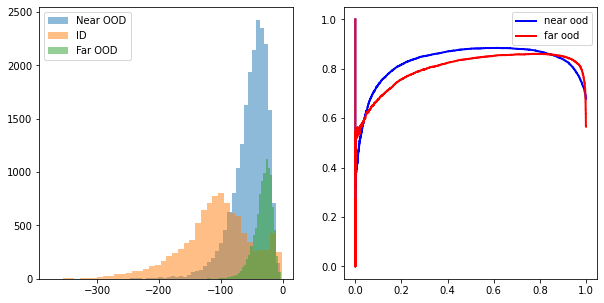

Near AUROC:0.8118027403846154, Far AUROC: 0.8981179699999999


In [24]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='DDU',reverse=True)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))